# **Run the Simulation**

## Import Packages

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from matplotlib import colors
import networkx as nx
import igraph as ig
import seaborn as sns
import json

from Functions import calculate_distance_to_bars, initialize_agents, step

## Define the Simulation

In [2]:
# Function to run the simulation for a given configuration
def run_simulation(config):
    # Extract parameters from the config dictionary
    num_students = config["num_students"]
    num_police = config["num_police"]
    steps = config["steps"]
    aggress_threshold = config["aggress_threshold"]
    mode = config["mode"]
    discount = config["discount"]
    graph_type = config["graph_type"]
    
    grid_height = 200  # Default grid height
    grid_width = 18   # Default grid width
    
    # Initialize agents
    students, police_officers, grid, layout_grid, friend_network = initialize_agents(grid_height, grid_width, num_students, num_police, graph_type)
    
    # Track data for plotting and analysis
    fight_history = []
    avg_aggressiveness_history = []
    fight_spots_grid = np.zeros((grid_height, grid_width))  # Initialize the grid to track fight spots
    steps_between_fights_history = []
    steps_between_fights = 0
    steps_taken_per_police = np.zeros(num_police)  # Track steps taken by each police officer

    # Start the simulation
    for step_num in range(steps):
        
        bar_discount = False  # Reset bar discount flag
        
        if step_num % 30 == 0 and discount:
            bar_discount = True  # Apply discount every 30 minutes 
        
        # Run one step of the simulation
        fight_counter = step(students, police_officers, mode, grid, layout_grid, aggress_threshold, fight_spots_grid, bar_discount)
        
        if fight_counter > 0:
            steps_between_fights = 0
        else:
            steps_between_fights += 1
        
        # Track the results
        fight_history.append(fight_counter)
        steps_between_fights_history.append(steps_between_fights)
        avg_aggressiveness = np.mean([s.aggressiveness for s in students])
        avg_aggressiveness_history.append(avg_aggressiveness)
    
    # After the simulation, calculate distances to bars
    distances = calculate_distance_to_bars(fight_spots_grid, grid_width)

    
    for i, police in enumerate(police_officers):
        steps_taken_per_police[i] = police.steps_taken

    return {
        "fight_history": fight_history,
        "steps_between_fights_history": steps_between_fights_history,
        "avg_aggressiveness_history": avg_aggressiveness_history,
        "distances": distances,
        "steps_taken_per_police": steps_taken_per_police,
        "fight_spots_grid": fight_spots_grid,
        'friendship_network': friend_network
    }


In [3]:
# Define the possible values for each parameter
num_students_range = [1500]  # Number of students
num_police_range = [10,30,50,200]    # Number of police officers
steps_range = [360]          # Number of steps
aggress_threshold_range = [0.9]  # Aggressiveness threshold
mode_range = ["distributed-strategic","strategic","random"]  # Mode of the simulation
discount_range = [True,False]  # Whether to apply discount
graph_type_range = ["watts","erdos"]  # Type of graph

# Generate all combinations of the parameters using itertools.product
configurations = list(itertools.product(
    num_students_range,
    num_police_range,
    steps_range,
    aggress_threshold_range,
    mode_range,
    discount_range,
    graph_type_range
))

# Convert each combination into a dictionary for easier use
configuration_dicts = [
    {
        "num_students": config[0],
        "num_police": config[1],
        "steps": config[2],
        "aggress_threshold": config[3],
        "mode": config[4],
        "discount": config[5],
        "graph_type": config[6]
    }
    for config in configurations
]

## Run the Simulation

In [6]:
def run_experiments(configurations, num_repeats=20):
    
    results = []
    configuration_counter = 0
    
    for config in configurations:
        for run in range(num_repeats):
            print(f"Running simulation {run + 1}/{num_repeats} for config: {config}")
            result = run_simulation(config)
            combined = config.copy()
            combined["run"] = run  # Track which repeat this is
            combined["configuration_id"] = configuration_counter
            combined.update(result)
            results.append(combined)
        configuration_counter += 1
        print(f"Completed configuration {configuration_counter}/{len(configurations)}")
        print("--------------------------------------------------")
    return results

In [7]:
results = run_experiments(configuration_dicts)

Running simulation 1/20 for config: {'num_students': 1500, 'num_police': 10, 'steps': 360, 'aggress_threshold': 0.9, 'mode': 'distributed-strategic', 'discount': True, 'graph_type': 'watts'}
Running simulation 2/20 for config: {'num_students': 1500, 'num_police': 10, 'steps': 360, 'aggress_threshold': 0.9, 'mode': 'distributed-strategic', 'discount': True, 'graph_type': 'watts'}
Running simulation 3/20 for config: {'num_students': 1500, 'num_police': 10, 'steps': 360, 'aggress_threshold': 0.9, 'mode': 'distributed-strategic', 'discount': True, 'graph_type': 'watts'}
Running simulation 4/20 for config: {'num_students': 1500, 'num_police': 10, 'steps': 360, 'aggress_threshold': 0.9, 'mode': 'distributed-strategic', 'discount': True, 'graph_type': 'watts'}
Running simulation 5/20 for config: {'num_students': 1500, 'num_police': 10, 'steps': 360, 'aggress_threshold': 0.9, 'mode': 'distributed-strategic', 'discount': True, 'graph_type': 'watts'}
Running simulation 6/20 for config: {'num_stu

In [8]:
array_columns = ['fight_spots_grid', 'fight_history', 'avg_aggressiveness_history', 'steps_taken_per_police','steps_between_fights_history','distances']

for r in results:
    for col in array_columns:
        if isinstance(r[col], np.ndarray):
            r[col] = json.dumps(r[col].tolist())
        elif isinstance(r[col], list):  # in case they’re Python lists already
            r[col] = json.dumps(r[col])

In [9]:
results_df = pd.DataFrame(results)

In [11]:
#Save the results to a CSV file
results_df.to_csv("simulation_results_20runs.csv", index=False)

## Analysis

In [12]:
# Read the results from the csv file
results_df = pd.read_csv("simulation_results_20runs.csv")

In [13]:
array_columns = ['fight_spots_grid', 'fight_history', 'avg_aggressiveness_history', 'steps_taken_per_police','steps_between_fights_history','distances']

for col in array_columns:
    results_df[col] = results_df[col].apply(lambda s: np.array(json.loads(s)))

### Pre-Process the results

In [17]:
# Drop the run column
results_df = results_df.drop(columns=["run"])

In [18]:
# Add column total_fights
results_df['total_fights'] = results_df['fight_history'].apply(lambda x: sum(x))

In [ ]:
results_df_without_strategic = results_df[results_df["mode"] != "strategic"]

## Get average fights per configuration with CI

In [21]:
import scipy.stats as stats

# Function to calculate mean and confidence interval
def mean_ci(series, confidence=0.95):
    n = len(series)
    mean = series.mean()
    sem = stats.sem(series)
    h = sem * stats.t.ppf((1 + confidence) / 2, n - 1)
    return pd.Series({'mean': mean, 'ci_lower': mean - h, 'ci_upper': mean + h})


In [41]:
# Group and apply the function
grouped_results = results_df.groupby('configuration_id')['total_fights'].apply(mean_ci).unstack().reset_index()

In [42]:
grouped_results.head()

,configuration_id,mean,ci_lower,ci_upper
0,0,328.25,249.773588,406.726412
1,1,197.60,144.093079,251.106921
2,2,232.70,172.716634,292.683366
3,3,194.05,156.026973,232.073027
4,4,298.25,207.122026,389.377974


In [43]:
# Add all configuration variables to the grouped results from the results_df
grouped_results = pd.merge(grouped_results, results_df[["configuration_id","num_police","mode","discount","graph_type"]], on="configuration_id", how="left")

# Remove duplicates
grouped_results = grouped_results.drop_duplicates(subset=["configuration_id"])

## Deep-Dive into Top Configuration

In [117]:
grouped_without_200police = grouped_results[grouped_results['num_police'] != 200]

In [118]:
# Get the top configuration with the least fights
top_configuration = grouped_without_200police.loc[grouped_without_200police['mean'].idxmin()]

In [45]:
# Get the results from results_df for the top 10 configurations
top_results = results_df[results_df['configuration_id'] == top_configuration['configuration_id']].copy()

In [3]:
# Run one simulation for the top configuration
top_config = {
    "num_students": 1500,
    "num_police": 30,
    "steps": 360,
    "aggress_threshold": 0.9,
    "mode": 'random',
    "discount": False,
    "graph_type": 'erdos'
}

In [8]:
# Run the simulation for the top configuration
top_simulation_result = run_simulation(top_config)

In [11]:
friends_network = top_simulation_result['friendship_network']

In [21]:
len(friends_network.edges())

112629

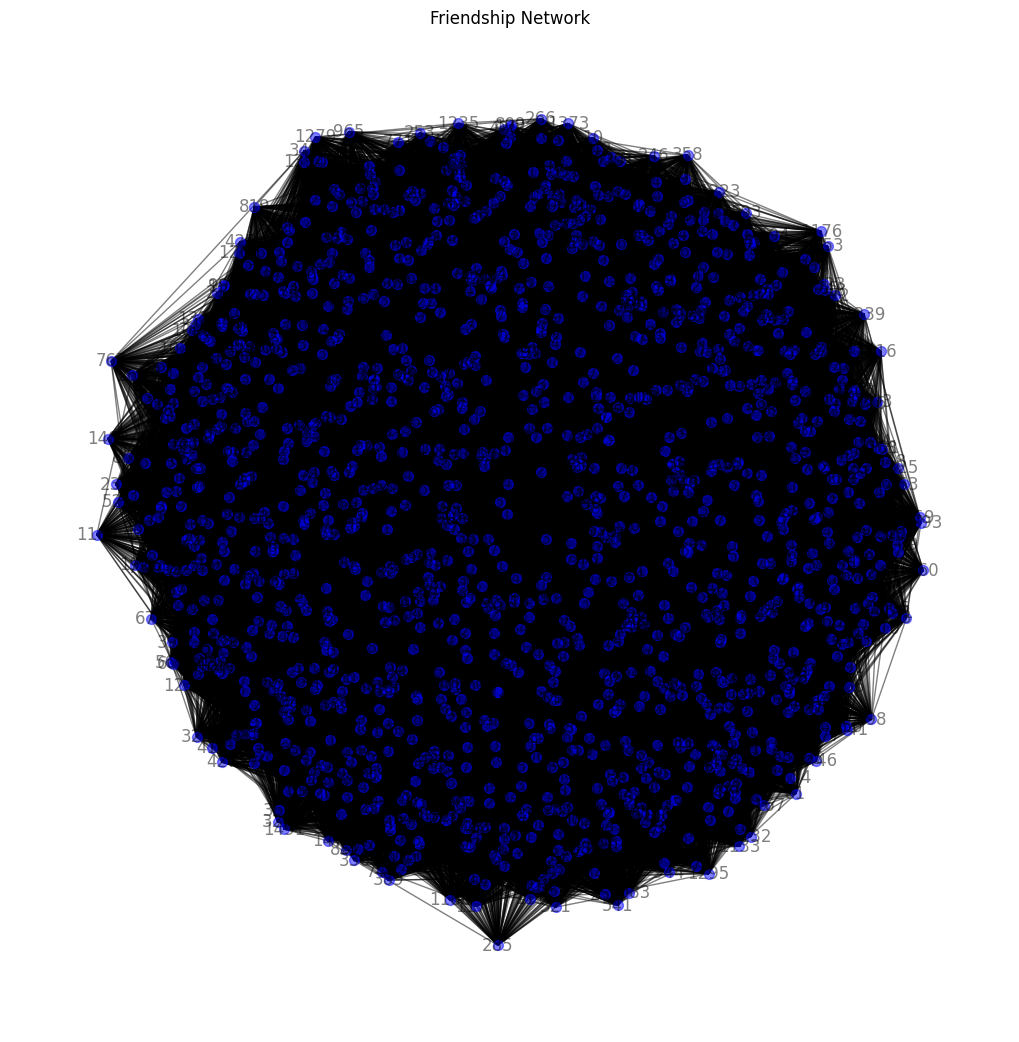

In [19]:
# Create a graph from friends_network.edges()
G = nx.Graph()
for edge in friends_network.edges():
    G.add_edge(edge[0], edge[1])
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, node_size=50, node_color='blue', alpha=0.5)
plt.title("Friendship Network")
plt.show()

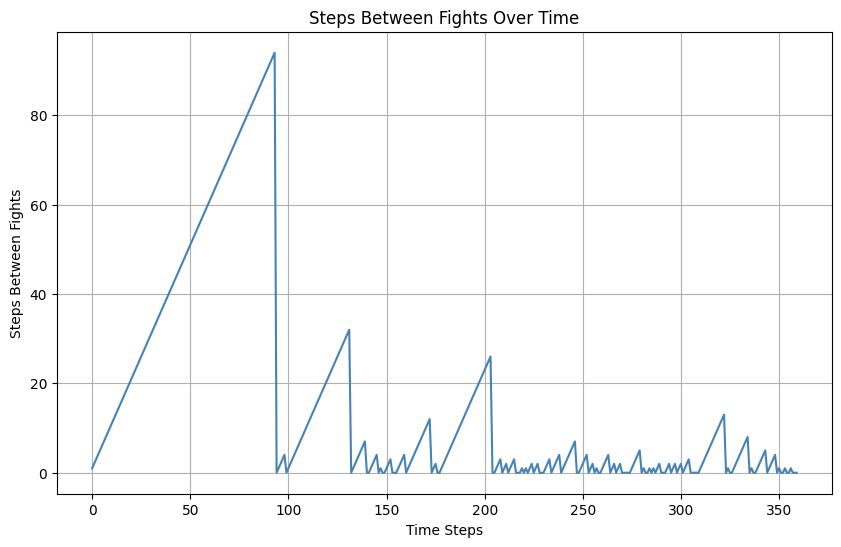

In [31]:
# Plot steps between fights for the top configuration
plt.figure(figsize=(10, 6))
plt.plot(top_simulation_result['steps_between_fights_history'], label='Steps Between Fights', color='steelblue')
plt.xlabel('Time Steps')
plt.ylabel('Steps Between Fights')
plt.title('Steps Between Fights Over Time')
plt.grid()
plt.show()


## Test relationship between factors and fights

In [48]:
import pandas as pd
import statsmodels.api as sm

# 1. Define the features and target
X = results_df_without_strategic[['num_police', 'discount', 'mode', 'graph_type']]
y = results_df_without_strategic['total_fights']

# 2. Convert categorical variables into dummies
X = pd.get_dummies(X, columns=['mode', 'graph_type'], drop_first=True)

# 3. Ensure all values are numeric (especially if discount is still bool)
X = X.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)

# 5. Add intercept
X = sm.add_constant(X)

# 6. Fit the linear model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_fights   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     14.14
Date:                Mon, 12 May 2025   Prob (F-statistic):           4.65e-11
Time:                        18:15:41   Log-Likelihood:                -4021.5
No. Observations:                 640   AIC:                             8053.
Df Residuals:                     635   BIC:                             8075.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              217.1242     11.429  

## Check Hypotheses

### H1: *"More police officers reduce the number of fights."*

/var/folders/wj/mg6ns4453bj1zwy6wtd0xh3w0000gn/T/ipykernel_57011/3602923238.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df_without_strategic, x='num_police', y='total_fights', palette="pastel", width=0.6, linewidth=1)


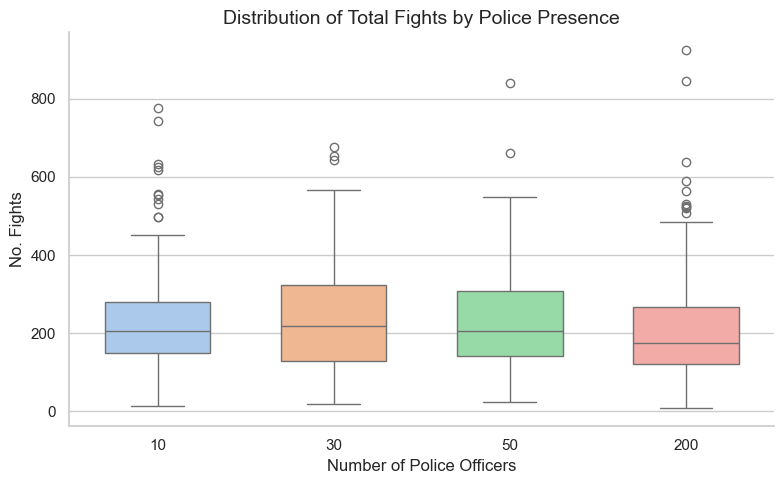

In [37]:
# Set a minimal style with pastel colors
sns.set(style="whitegrid", palette="pastel")

plt.figure(figsize=(8, 5))
sns.boxplot(data=results_df_without_strategic, x='num_police', y='total_fights', palette="pastel", width=0.6, linewidth=1)

# #Optional: overlay data points for more insight
# sns.stripplot(data=results_df, x='num_police', y='total_fights', 
#               color='gray', size=4, jitter=0.2, alpha=0.5)

# Labels and title
plt.xlabel("Number of Police Officers", fontsize=12)
plt.ylabel("No. Fights", fontsize=12)
plt.title("Distribution of Total Fights by Police Presence", fontsize=14)

# Clean up visual clutter
sns.despine()
plt.tight_layout()
plt.show()

In [28]:
police_results = results_df_without_strategic.groupby('num_police')['total_fights'].apply(mean_ci).unstack().reset_index()

In [29]:
police_results 

,num_police,mean,ci_lower,ci_upper
0,10,235.80000,214.603702,256.996298
1,30,237.07500,215.909454,258.240546
2,50,230.36875,210.645709,250.091791
3,200,209.62500,187.315466,231.934534


### H2: *"Randomly patrolling officers are less effective than strategically placed officers in high-risk areas."*

/var/folders/wj/mg6ns4453bj1zwy6wtd0xh3w0000gn/T/ipykernel_57011/4161423791.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='mode', y='total_fights', palette="pastel", width=0.6, linewidth=1)


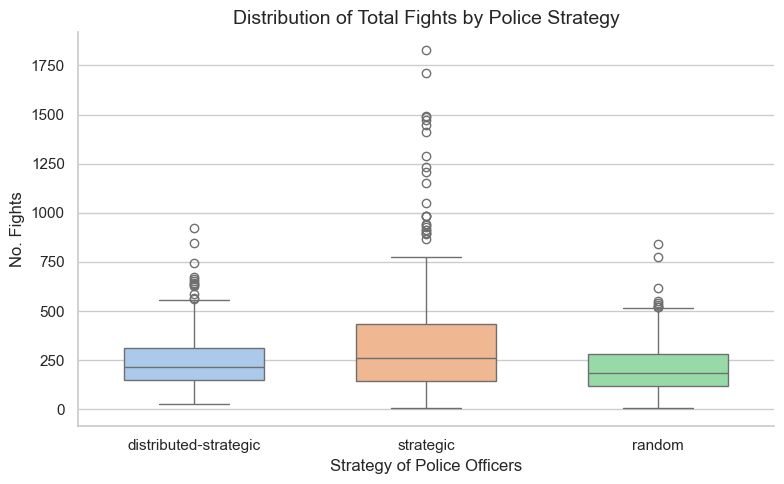

In [38]:
# Set a minimal style with pastel colors
sns.set(style="whitegrid", palette="pastel")

plt.figure(figsize=(8, 5))
sns.boxplot(data=results_df, x='mode', y='total_fights', palette="pastel", width=0.6, linewidth=1)

# #Optional: overlay data points for more insight
# sns.stripplot(data=results_df, x='num_police', y='total_fights', 
#               color='gray', size=4, jitter=0.2, alpha=0.5)

# Labels and title
plt.xlabel("Strategy of Police Officers", fontsize=12)
plt.ylabel("No. Fights", fontsize=12)
plt.title("Distribution of Total Fights by Police Strategy", fontsize=14)

# Clean up visual clutter
sns.despine()
plt.tight_layout()
plt.show()

In [39]:
strategy_results = results_df.groupby('mode')['total_fights'].apply(mean_ci).unstack().reset_index()
strategy_results

,mode,mean,ci_lower,ci_upper
0,distributed-strategic,245.734375,230.222354,261.246396
1,random,210.700000,196.697283,224.702717
2,strategic,345.021875,312.162633,377.881117


### H3: *"Fights will happen more often near the bars"*

In [59]:
def calculate_average_fights(fight_spots_grids):
    
    # Ensure all fight_spots_grids have the same shape
    grid_height, grid_width = fight_spots_grids[0].shape
    
    # Initialize a grid to accumulate the total number of fights
    total_fights_grid = np.zeros((grid_height, grid_width))
    
    # Accumulate fight counts from all runs
    for fight_spots_grid in fight_spots_grids:
        total_fights_grid += fight_spots_grid
    
    # Calculate the average number of fights per spot
    fights_grid = total_fights_grid 
    
    return fights_grid

In [60]:
total_fights_grid = calculate_average_fights(results_df["fight_spots_grid"].tolist())

In [77]:
# Plot the fight spots grid
def plot_fight_spots_grid(fight_spots_grid, title):
    
    plt.figure(figsize=(12, 4))  # Wider figure for horizontal street

    # Transpose to flip axes if needed (see next section)
    plt.imshow(fight_spots_grid.T, cmap='Reds', origin='lower')

    #plt.imshow(fight_spots_grid, cmap='Reds', origin='lower')
    plt.axis('off')  # Removes ticks and labels
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

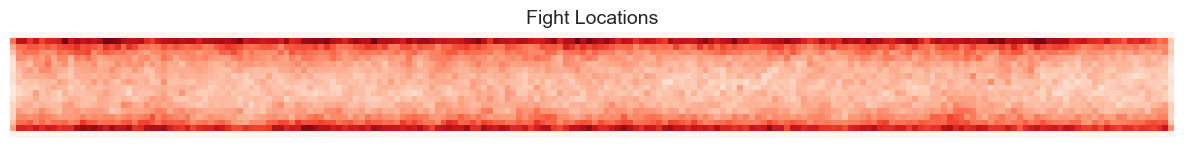

In [63]:
plot_fight_spots_grid(total_fights_grid, "Fight Spots Grid")

In [75]:
# Split the results into those with and without discount
results_with_discount = results_df[results_df["discount"] == True]
results_without_discount = results_df[results_df["discount"] == False]
# Calculate average fights for each group
average_fights_with_discount = calculate_average_fights(results_with_discount["fight_spots_grid"].tolist())
average_fights_without_discount = calculate_average_fights(results_without_discount["fight_spots_grid"].tolist())

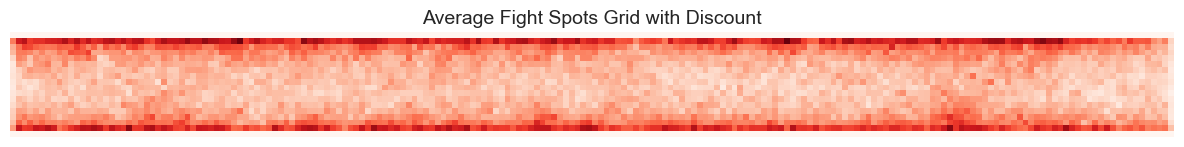

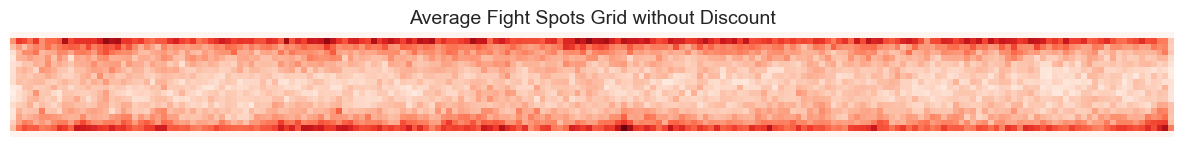

In [ ]:
# Plot the results for average fights with and without discount
plot_fight_spots_grid(average_fights_with_discount, "Fight Spots Grid with Discount")
plot_fight_spots_grid(average_fights_without_discount, "Fight Spots Grid without Discount")

In [82]:
# Get an mean of the distances to bars for each configuration
results_df["mean_distances"] = results_df["distances"].apply(lambda x: np.mean(x))

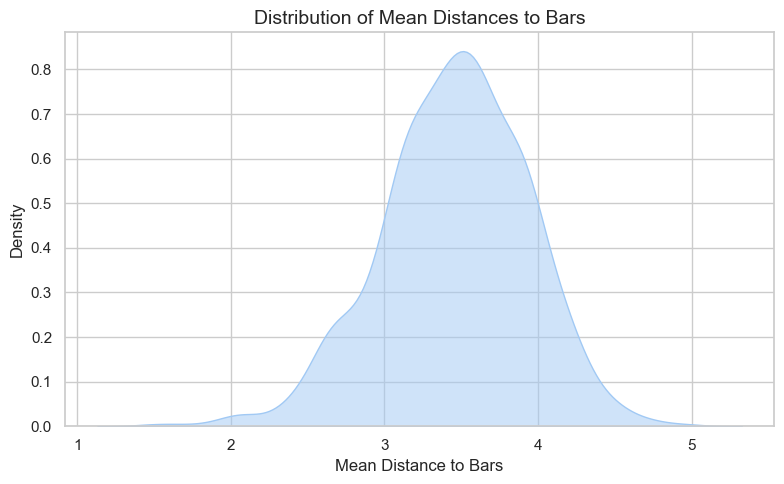

In [89]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=results_df, x='mean_distances', common_norm=False, fill=True, alpha=0.5)
plt.xlabel("Mean Distance to Bars", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution of Mean Distances to Bars", fontsize=14)
plt.tight_layout()
plt.show()

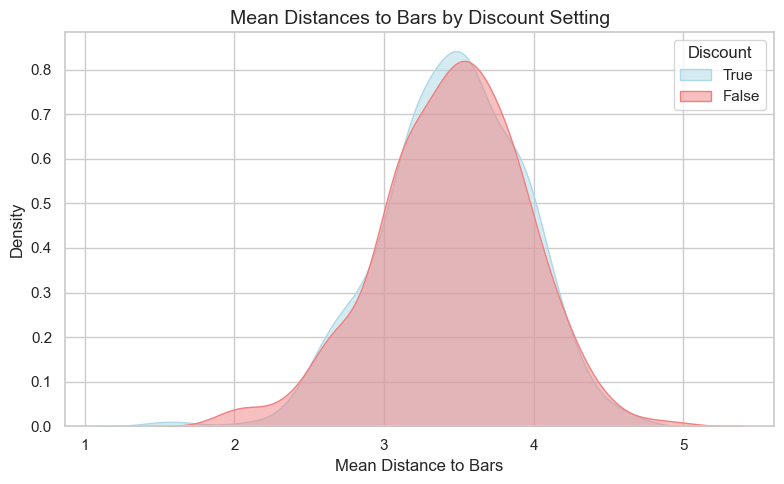

In [96]:
plt.figure(figsize=(8, 5))

# Ensure the 'discount' column is categorical
results_df['discount'] = results_df['discount'].astype('category')

# Specify the color palette manually (pastel colors for True and False)
palette = {True: 'lightblue', False: 'lightcoral'}

# Plot KDE with hue based on 'discount'
sns.kdeplot(data=results_df, x='mean_distances', hue='discount', common_norm=False, fill=True, alpha=0.5, palette=palette)

# Adding labels and title
plt.xlabel("Mean Distance to Bars", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Mean Distances to Bars by Discount Setting", fontsize=14)

# Manually set the legend for True and False
plt.legend(title='Discount', labels=['True', 'False'], loc='upper right')

# Tidy up layout to make sure everything fits nicely
plt.tight_layout()

# Show the plot
plt.show()

In [119]:
# Look at the average steps taken by police officers for the distributed-strategic mode
distributed_strategic_results = results_df[results_df["mode"] == "distributed-strategic"]

distributed_strategic_results['average_steps_taken'] = distributed_strategic_results['steps_taken_per_police'].apply(lambda x: np.mean(x))
steps_distribution = distributed_strategic_results.groupby('num_police')['average_steps_taken'].apply(mean_ci).unstack().reset_index()

/var/folders/wj/mg6ns4453bj1zwy6wtd0xh3w0000gn/T/ipykernel_57011/1347592238.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distributed_strategic_results['average_steps_taken'] = distributed_strategic_results['steps_taken_per_police'].apply(lambda x: np.mean(x))


In [120]:
steps_distribution

,num_police,mean,ci_lower,ci_upper
0,10,95.21250,90.725797,99.699203
1,30,68.81125,65.373639,72.248861
2,50,58.78375,55.498586,62.068914
3,200,18.73900,16.461781,21.016219


/var/folders/wj/mg6ns4453bj1zwy6wtd0xh3w0000gn/T/ipykernel_57011/3813236691.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distributed_strategic_results['num_police'] = distributed_strategic_results['num_police'].astype('string')
/var/folders/wj/mg6ns4453bj1zwy6wtd0xh3w0000gn/T/ipykernel_57011/3813236691.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=distributed_strategic_results,


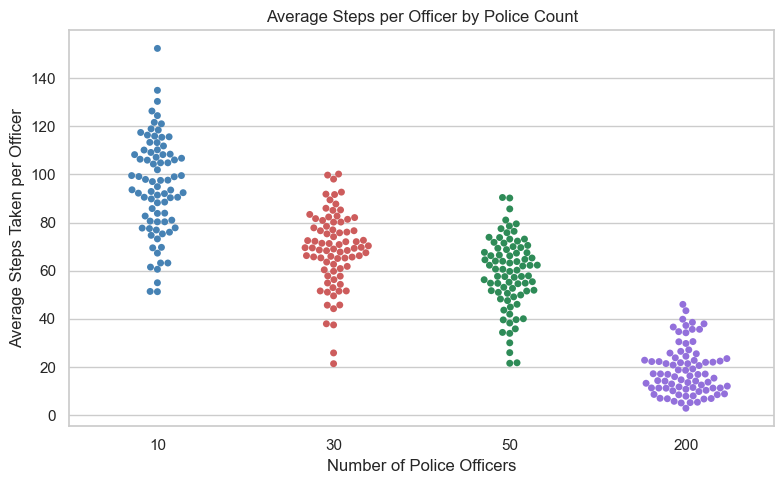

In [156]:
plt.figure(figsize=(8, 5))

# Ensure num_police is categorical or string for grouping
distributed_strategic_results['num_police'] = distributed_strategic_results['num_police'].astype('string')

# Beeswarm plot (like stripplot but with smarter jitter)
sns.swarmplot(data=distributed_strategic_results,
              x='num_police',
              y='average_steps_taken',
              palette={'10': 'steelblue', '30': 'indianred', '50': 'seagreen', '200': 'mediumpurple'})

# Labels and title
plt.xlabel("Number of Police Officers")
plt.ylabel("Average Steps Taken per Officer")
plt.title("Average Steps per Officer by Police Count")
plt.tight_layout()
plt.show()

### H4: *“Fights will happen more frequently towards the end of the evening.”*

In [65]:
# Average steps_between_fights over all runs
def calculate_average_steps_between_fights(steps_between_fights_history):
    
    # Initialize a list to accumulate the total number of steps
    total_steps = np.zeros(len(steps_between_fights_history[0]))
    
    # Accumulate steps from all runs
    for history in steps_between_fights_history:
        total_steps[:len(history)] += history
    
    # Calculate the average number of steps between fights
    avg_steps_between_fights = total_steps / len(steps_between_fights_history)
    
    return avg_steps_between_fights

In [66]:
average_steps_between = calculate_average_steps_between_fights(results_df["steps_between_fights_history"].tolist())

In [73]:
# Plot the average steps between fights
def plot_average_steps_between_fights(average_steps_between, title):
    
    plt.figure(figsize=(12, 4))  # Wider figure for horizontal street

    # Transpose to flip axes if needed (see next section)
    plt.plot(average_steps_between, color='blue', linewidth=2)

    plt.xlabel("Time Steps", fontsize=12)
    plt.ylabel("Average Steps Between Fights", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

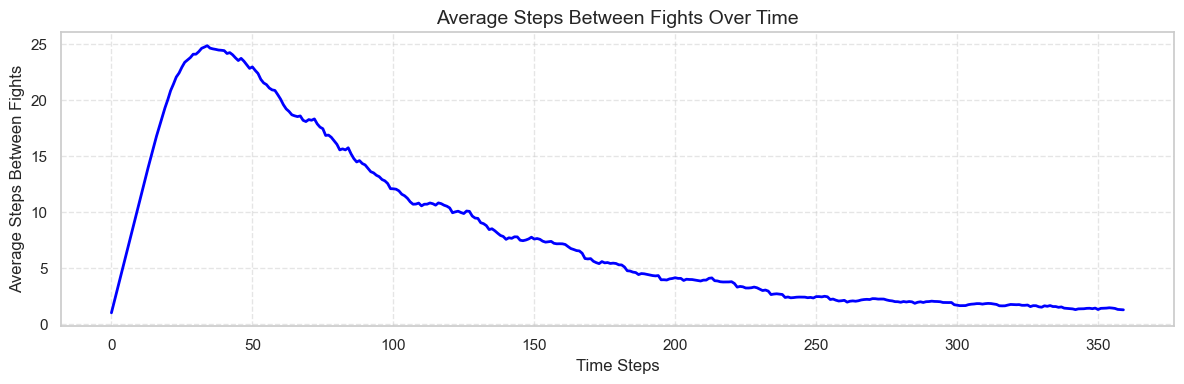

In [74]:
plot_average_steps_between_fights(average_steps_between, "Average Steps Between Fights Over Time")

### H5: *“Social Network Structure Influences Aggression Spread.”*

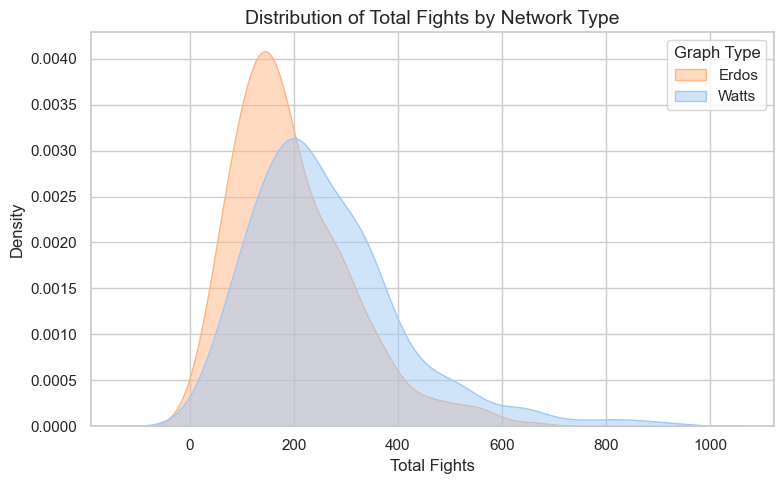

In [116]:
# Plot the KDE for total fights based on the graph type
plt.figure(figsize=(8, 5))
sns.kdeplot(data=results_df_without_strategic, x='total_fights', hue='graph_type', common_norm=False, fill=True, alpha=0.5)
plt.xlabel("Total Fights", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution of Total Fights by Network Type", fontsize=14)
plt.legend(title='Graph Type', labels=['Erdos', 'Watts'], loc='upper right')
plt.tight_layout()
plt.show()

In [114]:
network_results = results_df_without_strategic.groupby('graph_type')['total_fights'].apply(mean_ci).unstack().reset_index()
network_results

,graph_type,mean,ci_lower,ci_upper
0,erdos,196.306250,183.739690,208.872810
1,watts,260.128125,243.956708,276.299542


## Plot Results

In [ ]:
# Plot the fight spots grid
def plot_fight_spots_grid(fight_spots_grid, title):
    
    plt.figure(figsize=(12, 4))  # Wider figure for horizontal street

    # Transpose to flip axes if needed (see next section)
    plt.imshow(fight_spots_grid.T, cmap='Reds', origin='lower')

    #plt.imshow(fight_spots_grid, cmap='Reds', origin='lower')
    plt.axis('off')  # Removes ticks and labels
    plt.title("Fight Locations", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_fight_spots_grid(results[0]['fight_spots_grid'], "Fight Spots Grid")

In [ ]:
# Plot Average Aggressiveness
def plot_avg_aggressiveness(avg_aggressiveness_history, title):
    plt.plot(avg_aggressiveness_history)
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Average Aggressiveness')
    plt.show()

In [ ]:
plot_avg_aggressiveness(results[0]['avg_aggressiveness_history'], "Average Aggressiveness Over Time")

In [ ]:
# Plot graph object
def plot_graph(graph, title):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=50, node_color='blue', alpha=0.5)
    plt.title(title)
    plt.show()

In [ ]:
G = results[0]['friend_network']

plot_graph(G, "Friend Network Graph")

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities

communities = list(greedy_modularity_communities(G))

# Example: print the number of communities and their sizes
print(f"Detected {len(communities)} communities")
for i, community in enumerate(communities):
    print(f"Community {i + 1}: {len(community)} nodes")